# Cenaero

In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)

In [17]:
# Constants

NUM_SEQUENCES = 121
DATA_PATH = '../data/38Q31TzlO-{}/npz_data/data.npz'
PARAMS_PATH = '../data/38Q31TzlO-{}/Minamo_Parameters-Wall2D.txt'
SEED = 20210831

In [18]:
def load_data(simulation_ids, recurrent=False):

    inputs, targets = [], []

    for simulation_id in simulation_ids:

        data = np.load(DATA_PATH.format(simulation_id))

        # Extract input data: `t`, `x_t`, `P_t`
        time = torch.from_numpy(data['time']).float()
        laser_position = torch.from_numpy(data['laser_position_x']).float()
        laser_power = torch.from_numpy(data['laser_power']).float()

        # Parse parameters
        with open(PARAMS_PATH.format(simulation_id)) as params_file:
            lines = params_file.read().splitlines()
            power = float(lines[0].split(' = ')[1])
            break_time = float(lines[1].split(' = ')[1])

        if recurrent:
            # Create a feature `delta`
            delta = time.clone()
            delta[1:] = time[1:] - time[:-1]
            input = torch.stack((delta, laser_position, laser_power), dim=1)
        else:
            # Create features `P` and `b`
            power = torch.full(laser_power.shape, power)
            break_time = torch.full(laser_power.shape, break_time)

            input = torch.stack(
                (time, laser_position, laser_power, power, break_time),
                dim=1)

        # Extract target data: `P^1_t`, ..., `P^6_t`
        target = torch.stack(
            [torch.from_numpy(data['T{}'.format(i + 1)]).float()
                for i in range(6)],
            dim=1)

        # TODO: delete this
        if recurrent:
            input = input[::20, :]
            target = target[::20, :]

        inputs.append(input)
        targets.append(target)

    # Extract sequences lengths
    seq_lengths = torch.tensor([len(input) for input in inputs])

    if recurrent:
        # Pad sequences and stack them to create the dataset
        inputs = nn.utils.rnn.pad_sequence(inputs)
        targets = nn.utils.rnn.pad_sequence(targets)

    else:
        # Concatenate all sequences to create the dataset
        inputs = torch.cat(inputs, dim=0)
        targets = torch.cat(targets, dim=0)

    return inputs, targets, seq_lengths


def train_valid_test_split(sequence_ids, recurrent=False, train_ratio=0.7,
        seed=20210831):

    # Shuffle sequences with a random seed
    torch.random.manual_seed(seed)
    n_sequences = len(sequence_ids)
    permutation = torch.randperm(n_sequences)
    shuffled_ids = torch.tensor(sequence_ids)[permutation]

    # Split sequences
    end_train = int(train_ratio * n_sequences)
    end_valid = int((train_ratio + 0.5 * (1.0 - train_ratio)) * n_sequences)

    train_ids = shuffled_ids[:end_train]
    valid_ids = shuffled_ids[end_train:end_valid]
    test_ids = shuffled_ids[end_valid:]

    train_dataset = load_data(train_ids, recurrent)
    valid_dataset = load_data(valid_ids, recurrent)
    test_dataset = load_data(test_ids, recurrent)

    return train_dataset, valid_dataset, test_dataset

## Train, test and validation split

In [19]:
train_dataset, valid_dataset, test_dataset = train_valid_test_split(range(1, NUM_SEQUENCES + 1),
                                                                    recurrent=False,
                                                                    train_ratio=0.7)
train_inputs, train_targets, train_seq_lengths = train_dataset
valid_inputs, valid_targets, valid_seq_lengths = valid_dataset
test_inputs, test_targets, test_seq_lengths = test_dataset

17892.191053038398


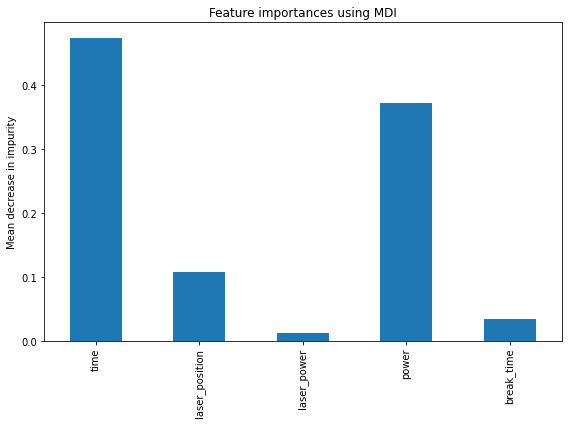

In [23]:
# Decision Tree training
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Pipeline (standardizer -> model)
pipe = make_pipeline(StandardScaler(), 
                     DecisionTreeRegressor(max_depth=None, random_state=SEED))
pipe.fit(train_inputs, train_targets)

# Decision Tree evaluation
test_preds = pipe.predict(test_inputs)
MSE = (((torch.from_numpy(test_preds) - test_targets) ** 2).sum() / test_targets.shape[0]).item()
print(MSE)

# Get feature importance
feature_names = [f'{i}' for i in ['time', 'laser_position', 'laser_power', 'power', 'break_time']]
importances = pipe.named_steps['decisiontreeregressor'].feature_importances_

dt_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
dt_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig('output/dt_feature_importance.pdf', transparent=True)

10873.741767364309


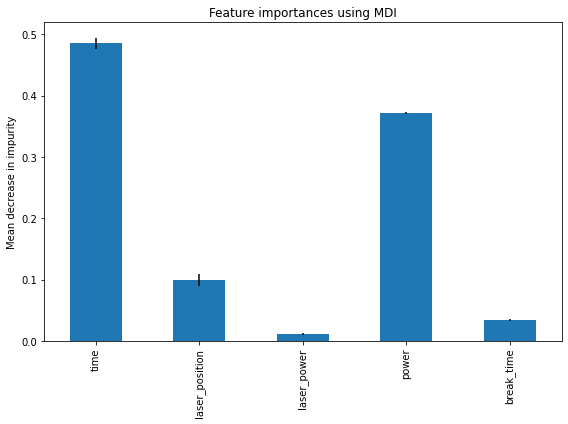

In [24]:
# Random Forest training
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Pipeline (standardizer -> model)
pipe = make_pipeline(StandardScaler(), 
                     RandomForestRegressor(n_estimators=200, max_depth=None, n_jobs=-1, random_state=SEED))
pipe.fit(train_inputs, train_targets)

# Random Forest evaluation
test_preds = pipe.predict(test_inputs)
MSE = (((torch.from_numpy(test_preds) - test_targets) ** 2).sum() / test_targets.shape[0]).item()
print(MSE)

# Get feature importance
feature_names = [f'{i}' for i in ['time', 'laser_position', 'laser_power', 'power', 'break_time']]

importances = pipe.named_steps['randomforestregressor'].feature_importances_
std = np.std([tree.feature_importances_ for tree in pipe.named_steps['randomforestregressor'].estimators_], axis=0)

rf_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig('output/rf_feature_importance.pdf', transparent=True)

5610.491652365402


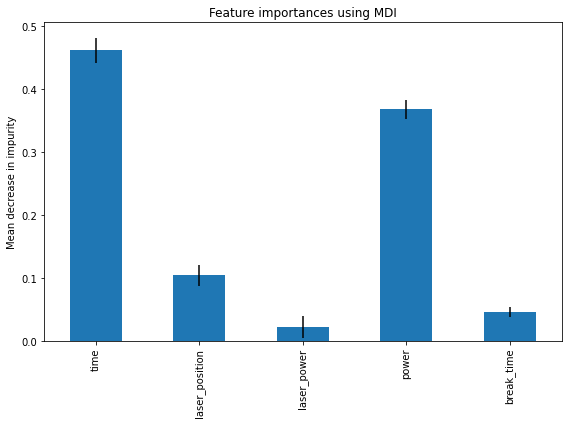

In [25]:
# Extra Trees training
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Pipeline (standardizer -> model)
pipe = make_pipeline(StandardScaler(), 
                     ExtraTreesRegressor(n_estimators=200, max_depth=None, n_jobs=-1, random_state=SEED))
pipe.fit(train_inputs, train_targets)

# Extra Trees evaluation
test_preds = pipe.predict(test_inputs)
MSE = (((torch.from_numpy(test_preds) - test_targets) ** 2).sum() / test_targets.shape[0]).item()
print(MSE)

# Get feature importance
feature_names = [f'{i}' for i in ['time', 'laser_position', 'laser_power', 'power', 'break_time']]

importances = pipe.named_steps['extratreesregressor'].feature_importances_
std = np.std([tree.feature_importances_ for tree in pipe.named_steps['extratreesregressor'].estimators_], axis=0)

xt_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
xt_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig('output/xt_feature_importance.pdf', transparent=True)

### Plot results

In [10]:
# Choose random evaluation sequence
sample_test_id = np.random.choice(test_sequence_ids, size=(1,))
sample_test_inputs, sample_test_targets = load_data(sample_test_id, recurrent=False)

sample_test_preds = dt.predict(sample_test_inputs)

NameError: name 'dt' is not defined

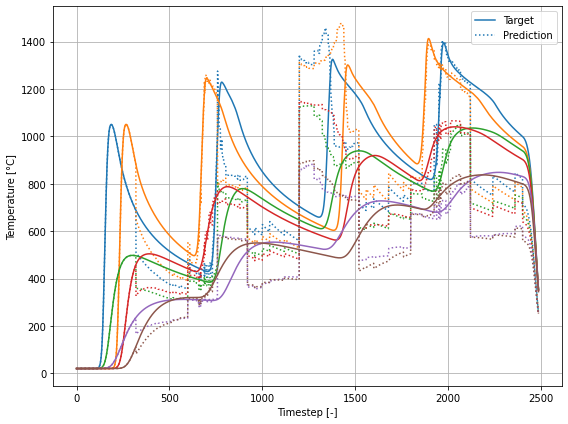

In [52]:
import os

os.makedirs('output', exist_ok=True)

fig, ax = plt.subplots()
for i in range(6):
    ax.plot(sample_test_targets[:, i], color='C{}'.format(i), label='Target')
    ax.plot(sample_test_preds[:, i], color='C{}'.format(i), linestyle=':', label='Prediction')
    
ax.grid()
ax.set_xlabel(r'Timestep [-]')
ax.set_ylabel(r'Temperature [°C]')
handles, labels = ax.get_legend_handles_labels()
handles = handles[:2]
labels = labels[:2]
ax.legend(handles, labels)
plt.tight_layout()
plt.savefig('output/dt_test_4features.pdf', transparent=True)

### Multilayer Perceptron

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MLP(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_hidden, output_size):
        
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_hidden = num_hidden
        self.output_size = output_size
        
        hidden = []
        for _ in range(self.num_hidden - 1):
            hidden.append(nn.Linear(self.hidden_size, self.hidden_size))
            hidden.append(nn.ReLU())
            
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            *hidden,
            nn.Linear(self.hidden_size, self.output_size)
        )
        
    def forward(self, x):
        return self.layers(x)

In [103]:
train_inputs = torch.from_numpy(train_inputs).float()
train_targets = torch.from_numpy(train_targets).float()
eval_inputs = torch.from_numpy(eval_inputs).float()
eval_targets = torch.from_numpy(eval_targets).float()
test_inputs = torch.from_numpy(test_inputs).float()
test_targets = torch.from_numpy(test_targets).float()

TypeError: expected np.ndarray (got Tensor)

In [113]:
# Hyperparameters
LR = 1e-3
BATCH_SIZE = 32
INPUT_SIZE = train_inputs.shape[1]
HIDDEN_SIZE = 32
NUM_HIDDEN = 2
OUTPUT_SIZE = train_targets.shape[1]
N_EPOCHS_CONVERGENCE = 5

In [126]:
mlp = MLP(
    INPUT_SIZE,
    HIDDEN_SIZE,
    NUM_HIDDEN,
    OUTPUT_SIZE
)

optimizer = optim.Adam(mlp.parameters(), lr=LR)

In [127]:
from copy import deepcopy

# Train model
best_loss, nb_epoch_no_improvement, best_weights = np.inf, 0, deepcopy(mlp.state_dict())
train_losses, eval_losses = [], []
epoch = 0
while nb_epoch_no_improvement <= N_EPOCHS_CONVERGENCE:
    
    # TRAINING PHASE
    train_loss = 0.0
    permutation = torch.randperm(train_inputs.shape[0])
    for b in range(0, train_inputs.shape[0], BATCH_SIZE):
        batch_indices = permutation[b:b+BATCH_SIZE]
        batch_inputs = train_inputs[batch_indices]
        batch_targets = train_targets[batch_indices]
        
        batch_preds = mlp(batch_inputs)
        loss = F.mse_loss(batch_preds, batch_targets)
        
        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= int(train_inputs.shape[0] / BATCH_SIZE)
    train_losses.append(train_loss)
    
    # VALIDATION PHASE
    val_loss = 0.0
    with torch.no_grad():
        eval_preds = mlp(eval_inputs)
        eval_loss = F.mse_loss(eval_preds, eval_targets).item()
    eval_losses.append(eval_loss)
    
    # UPDATE STATISTICS
    if eval_loss < best_loss:
        best_loss = eval_loss
        best_weights = deepcopy(mlp.state_dict())
        nb_epoch_no_improvement = 0
    else:
        nb_epoch_no_improvement += 1
    epoch += 1
        
    print('Epoch {:03d}, train loss: {:.4f}, val loss: {:.4f}'.format(epoch, train_loss, eval_loss))

# Load best weights
mlp.load_state_dict(best_weights)

Epoch 001, train loss: 28318.8577, val loss: 13366.7734
Epoch 002, train loss: 11535.6951, val loss: 10521.5352
Epoch 003, train loss: 9490.2996, val loss: 8667.8096
Epoch 004, train loss: 7761.0147, val loss: 7332.5298
Epoch 005, train loss: 6574.8221, val loss: 6061.9688
Epoch 006, train loss: 5503.5043, val loss: 4854.6323
Epoch 007, train loss: 4595.0486, val loss: 4113.8843
Epoch 008, train loss: 3901.6121, val loss: 3722.7346
Epoch 009, train loss: 3317.4885, val loss: 3269.8547
Epoch 010, train loss: 2835.1152, val loss: 2560.1653
Epoch 011, train loss: 2455.7510, val loss: 2272.6079
Epoch 012, train loss: 2158.8038, val loss: 2039.3966
Epoch 013, train loss: 1918.0789, val loss: 1914.7341
Epoch 014, train loss: 1700.4476, val loss: 1690.5908
Epoch 015, train loss: 1529.7797, val loss: 1456.3080
Epoch 016, train loss: 1415.5635, val loss: 1456.4000
Epoch 017, train loss: 1312.7332, val loss: 1321.3804
Epoch 018, train loss: 1242.4419, val loss: 1340.3982
Epoch 019, train loss: 1

<All keys matched successfully>

### Evaluate the MLP

In [11]:
# Choose random evaluation sequence and plot its prediction
sample_eval_id = np.random.choice(eval_sequence_ids, size=(1,))
sample_eval_inputs, sample_eval_targets = load_data(sample_eval_id, recurrent=False)
sample_eval_inputs = torch.from_numpy(sample_eval_inputs).float()
sample_eval_targets = torch.from_numpy(sample_eval_targets).float()

with torch.no_grad():
    sample_eval_preds = mlp(sample_eval_inputs)

for i in range(6):
    plt.plot(sample_eval_targets[:, i], color='C{}'.format(i), label='Target {}'.format(i))
    plt.plot(sample_eval_preds[:, i], color='C{}'.format(i), linestyle=':', label='Prediction {}'.format(i))
    plt.grid()
#     plt.legend()

NameError: name 'torch' is not defined

### Recurrent Neural Network

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.optim import lr_scheduler


class RNN(nn.Module):
    
    def __init__(self, input_size, cell, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        if cell == 'gru':
            self.rnn = nn.GRU(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers
            )
        elif cell == 'lstm':
            self.rnn = nn.LSTM(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers
            )
        else:
            raise NotImplementedError
            
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size)
        )
            
    def forward(self, x, h0=None):
        x, hn = self.rnn(x, h0)
        return self.mlp(x), hn

In [14]:
# Load data and pad it
train_inputs, train_targets, train_in_seq_lens, train_tar_seq_lens = load_data(train_sequence_ids, recurrent=True)
eval_inputs, eval_targets, eval_in_seq_lens, eval_tar_seq_lens = load_data(eval_sequence_ids, recurrent=True)
test_inputs, test_targets, test_in_seq_lens, test_tar_seq_lens = load_data(test_sequence_ids, recurrent=True)

train_inputs = torch.from_numpy(train_inputs).float()
train_in_seq_lens = torch.LongTensor(train_in_seq_lens)
train_targets = torch.from_numpy(train_targets).float()
train_tar_seq_lens = torch.LongTensor(train_tar_seq_lens)
eval_inputs = torch.from_numpy(eval_inputs).float()
eval_in_seq_lens = torch.LongTensor(eval_in_seq_lens)
eval_targets = torch.from_numpy(eval_targets).float()
eval_tar_seq_lens = torch.LongTensor(eval_tar_seq_lens)
test_inputs = torch.from_numpy(test_inputs).float()
test_in_seq_lens = torch.LongTensor(test_in_seq_lens)
test_targets = torch.from_numpy(test_targets).float()
test_tar_seq_lens = torch.LongTensor(test_tar_seq_lens)

print(train_inputs.shape)
print(train_targets.shape)

NameError: name 'train_sequence_ids' is not defined

In [20]:
# Hyperparameters
LR = 1e-3
BATCH_SIZE = 16
INPUT_SIZE = train_inputs.shape[2]
OUTPUT_SIZE = train_targets.shape[2]
HIDDEN_SIZE = 256
NUM_LAYERS = 2
N_EPOCHS_CONVERGENCE = 5

rnn = RNN(
    INPUT_SIZE,
    'gru',
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE
)

optimizer = optim.Adam(rnn.parameters(), lr=LR)

In [21]:
from copy import deepcopy

# Train model
best_loss, nb_epoch_no_improvement, best_weights = np.inf, 0, deepcopy(rnn.state_dict())
train_losses, eval_losses = [], []
epoch = 0
while nb_epoch_no_improvement <= N_EPOCHS_CONVERGENCE:
    
    # TRAINING PHASE
    train_loss = 0.0
    permutation = torch.randperm(train_inputs.shape[1])
    for b in range(0, train_inputs.shape[1], BATCH_SIZE):
        batch_indices = permutation[b:b+BATCH_SIZE]
        batch_lengths = train_seq_lengths[batch_indices]
        batch_masks = torch.arange(batch_lengths.max()).expand(len(batch_lengths), batch_lengths.max()) < batch_lengths.unsqueeze(1)
        batch_masks = batch_masks.T.unsqueeze(-1)

        batch_inputs = train_inputs[:batch_lengths.max(), batch_indices, :]
        batch_targets = train_targets[:, batch_indices, :]
        
        batch_preds, batch_hn = rnn(batch_inputs)
        batch_preds *= batch_masks
        
        batch_targets = batch_targets[:batch_lengths.max(), :, :]
        
        loss = F.mse_loss(batch_preds, batch_targets)
        
        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= int(train_inputs.shape[1] / BATCH_SIZE)
    train_losses.append(train_loss)
    
    # VALIDATION PHASE
    val_loss = 0.0
    packed_eval_inputs = valid_inputs[:valid_seq_lengths.max(), :, :]
    with torch.no_grad():
        eval_preds, eval_hn = rnn(packed_eval_inputs)
        eval_loss = F.mse_loss(eval_preds, valid_targets).item()
    eval_losses.append(eval_loss)
    
    # UPDATE STATISTICS
    if eval_loss < best_loss:
        best_loss = eval_loss
        best_weights = deepcopy(rnn.state_dict())
        nb_epoch_no_improvement = 0
    else:
        nb_epoch_no_improvement += 1
    epoch += 1
        
    print('Epoch {:03d}, train loss: {:.4f}, val loss: {:.4f}'.format(epoch, train_loss, eval_loss))

# Load best weights
rnn.load_state_dict(best_weights)

Epoch 001, train loss: 337793.5687, val loss: 284413.8438
Epoch 002, train loss: 324964.0719, val loss: 279719.2812
Epoch 003, train loss: 294793.4359, val loss: 272986.7188
Epoch 004, train loss: 293610.3281, val loss: 263642.8438
Epoch 005, train loss: 289815.2375, val loss: 251519.1406
Epoch 006, train loss: 280847.7594, val loss: 236779.1875
Epoch 007, train loss: 252249.2062, val loss: 219929.5469
Epoch 008, train loss: 248447.9156, val loss: 201636.9062
Epoch 009, train loss: 209027.8891, val loss: 182557.4531
Epoch 010, train loss: 190984.8656, val loss: 164004.7500
Epoch 011, train loss: 161660.9844, val loss: 147015.2812
Epoch 012, train loss: 147420.4375, val loss: 132923.9219
Epoch 013, train loss: 141946.5141, val loss: 122147.5391
Epoch 014, train loss: 108452.7883, val loss: 113957.7969
Epoch 015, train loss: 87371.6703, val loss: 107972.2969
Epoch 016, train loss: 74569.4508, val loss: 104772.5312
Epoch 017, train loss: 65679.7258, val loss: 105203.3359
Epoch 018, train 

KeyboardInterrupt: 

torch.Size([141, 1, 3])
(141, 1, 6)


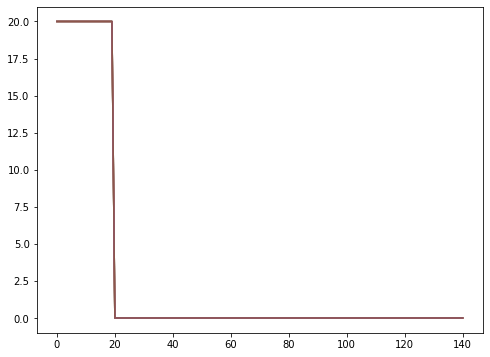

In [18]:
sample_train_id = np.random.choice(train_sequence_ids, size=(1,))
sample_train_inputs, sample_train_targets, _, _ = load_data(sample_train_id, recurrent=True)
sample_train_inputs = torch.from_numpy(sample_train_inputs).float()

print(sample_train_inputs.shape)
print(sample_train_targets.shape)

with torch.no_grad():
    sample_train_preds, _ = rnn(sample_train_inputs)

plt.plot(sample_train_targets[:, 0, :])

torch.Size([85, 1, 3])
(85, 1, 6)


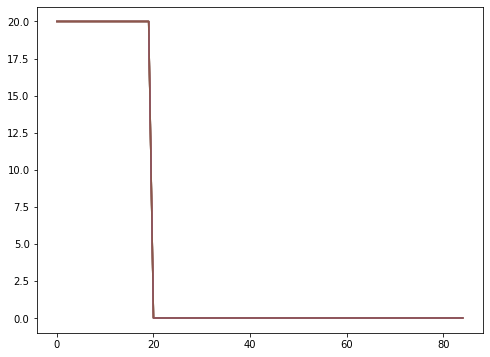

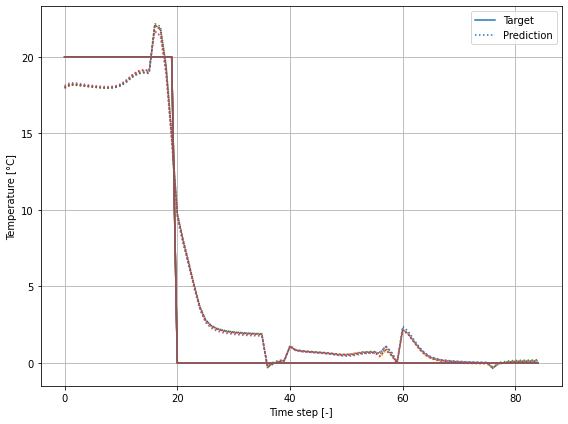

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid()
for i in range(6):
    ax.plot(sample_train_targets[:, 0, i], color='C{}'.format(i), label='Target')
    ax.plot(sample_train_preds[:, 0, i], color='C{}'.format(i), linestyle=':', label='Prediction')
handles, labels = ax.get_legend_handles_labels()
handles = handles[:2]
labels = labels[:2]
ax.legend(handles, labels)
ax.set_xlabel('Time step [-]')
ax.set_ylabel('Temperature [°C]')
plt.tight_layout()
plt.savefig('output/rnn-train.pdf', transparent=True)